# Implémentez un modèle de scoring

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Résumé du projet


## Chargement des bibliothèques nécessaires

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import seaborn as sns
import os
import shutil
import re
from zipfile import ZipFile
from os import listdir
from pathlib import Path
import glob

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
import time
from sklearn.model_selection import KFold,train_test_split,cross_val_score, GridSearchCV

from sklearn.metrics import roc_auc_score,roc_curve,f1_score, accuracy_score
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.metrics import precision_recall_curve,recall_score,precision_score,fbeta_score,average_precision_score

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter(action='ignore', category=Warning)

## Données

In [3]:
dir_data = Path('/content/drive/MyDrive/Data_Scientist/DATA/P7_inter') 
dir_fig  = Path('/content/drive/MyDrive/Data_Scientist/FIGURE') 

under=1
if under==1:
  filetrain=str(dir_data) + '/data_merged_train2use_under.csv'
else:
  filetrain=str(dir_data) + '/data_merged_train2use_over.csv'


In [4]:
data =pd.read_csv(filetrain)

### Prep for modelling

In [40]:


#data= data.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X=data.drop(['TARGET'],axis=1)
Y=data['TARGET']

In [41]:
X=X.drop(['Unnamed: 0'],axis=1)
fullstring='_ID_'
for i in X.columns:
    if fullstring in i:
      X=data.drop([i],axis=1)


In [42]:
seed=42
scalar    = preprocessing.StandardScaler() 
std_scalar = scalar.fit(X) 
X_scaled  = std_scalar.transform(X)
X_scaled  = pd.DataFrame(X_scaled,columns=X.columns)

In [43]:
[X_train,X_test,Y_train,Y_test]=train_test_split(X_scaled,Y,test_size=0.3, random_state=seed)

## Modèlisation

In [44]:
Classifiers = {
    "DummyClassifier":DummyClassifier(strategy="most_frequent"),
    "LGBMClassifier": LGBMClassifier(),
    "RandomForestClassifier": RandomForestClassifier(random_state=seed),
    "XGBClassifier": XGBClassifier(),
    }
params_Classifiers = {
    "DummyClassifier" :      {},
    "LGBMClassifier":        {'max_depth': [5, 10, 50],'learning_rate': [0.01, 0.1, 0.2],'n_estimators': [20,50, 100],'eval_metric' :['mlogloss']}, 
    "RandomForestClassifier":{'max_depth': [3, 10, 50],'max_features' : [    2,  3,   5],'n_estimators': [20,50, 100] }, 
    "XGBClassifier":         {'max_depth': [5, 10, 50],'learning_rate': [0.01, 0.1, 0.2],'n_estimators': [20, 50,100],'eval_metric' :['mlogloss'] },  
    }  # 'eval_metric' :['mlogloss']  to remove warnings

In [ ]:
nsplits=20
best_params = {}
results= pd.DataFrame(index=['accuracy','F1','FB','RECALL','PRECISION','ROC_AUC']) 
for model_idx in Classifiers:
    kfold = KFold(n_splits=nsplits, shuffle=True, random_state=seed)
    #
    print(model_idx)
    model  = Classifiers[model_idx]
    param_grid= params_Classifiers[model_idx]
    grid_search = GridSearchCV(estimator=model , param_grid=param_grid, cv=kfold)
    grid_search.fit(X_train, Y_train)
    best_params[model_idx]=grid_search.best_params_
    #       
    y_pred_tr      = grid_search.predict(X_train)
    y_pred_proba_tr= grid_search.predict_proba(X_train)[:,1]
    #    
    # Funtion cout
    acu_score_tr   = accuracy_score(Y_train, y_pred_tr)
    f1_score_tr    = f1_score(Y_train, y_pred_tr, average='weighted')
    fb_score_tr    = fbeta_score(Y_train, y_pred_tr, average='weighted',beta=5)
    recall_score_tr= recall_score(Y_train, y_pred_tr, average='weighted')
    pres_score_tr  = precision_score(Y_train, y_pred_tr, average='weighted')
    auc_score_tr   = roc_auc_score(Y_train, y_pred_proba_tr)   
    results[model_idx]=[acu_score_tr,f1_score_tr,fb_score_tr,recall_score_tr,pres_score_tr,auc_score_tr ]

DummyClassifier
LGBMClassifier
RandomForestClassifier
XGBClassifier


In [11]:
 results

,DummyClassifier,LGBMClassifier,RandomForestClassifier,XGBClassifier
accuracy,0.500331,0.732729,0.665084,0.724011
F1,0.333701,0.732727,0.664858,0.723995
FB,0.481824,0.732729,0.665036,0.724007
RECALL,0.500331,0.732729,0.665084,0.724011
PRECISION,0.250331,0.732733,0.665509,0.724057
ROC_AUC,0.500000,0.809825,0.723635,0.803251


In [12]:
best_params

{'DummyClassifier': {},
 'LGBMClassifier': {'eval_metric': 'mlogloss',
  'learning_rate': 0.1,
  'max_depth': 10,
  'n_estimators': 50},
 'RandomForestClassifier': {'max_depth': 5,
  'max_features': 3,
  'n_estimators': 50},
 'XGBClassifier': {'eval_metric': 'mlogloss',
  'learning_rate': 0.1,
  'max_depth': 5,
  'n_estimators': 50}}

In [36]:

def Model_Classifier(Classifiers,params_Classifiers,X_train, y_train,X_test,y_test,n_splits,seed):
    
    results= pd.DataFrame(index=['ACCURACY','F1','FB','RECALL','PRECISION','ROC_AUC'])  
    
    Findex=['Cible predite']    
    frames_test= [] 
    Import_Feature=[]
    column_Classifiers=[]
    col_Class=[]

    feature_importance_df = pd.DataFrame()
    feats = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

    for ks in Classifiers:
        column_Classifiers.append(ks)
#----------------------------------------------------------------

    for model_idx in Classifiers:
        
        start_time = time.time()
        #
        print(model_idx)
        model  = Classifiers[model_idx]
        #
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:,1]
        
        # Funtion cout
        acu_score_te   = accuracy_score(Y_test, y_pred)
        f1_score_te    = f1_score(Y_test, y_pred, average='weighted')
        fb_score_te    = fbeta_score(Y_test, y_pred, average='weighted',beta=5)
        recall_score_te= recall_score(Y_test, y_pred, average='weighted')
        pres_score_te  = precision_score(Y_test, y_pred, average='weighted')
        auc_score_te   = roc_auc_score(Y_test, y_pred_proba)  
        
        
        results[model_idx]=[acu_score_te,f1_score_te,fb_score_te, recall_score_te,pres_score_te,auc_score_te]

        y_pred=pd.DataFrame(y_pred,index=y_test.index,columns=Findex)
        
        Y_pred_test= pd.concat([y_test,y_pred],axis=1)
        frames_test.append(Y_pred_test)
        
        ### Check Feature Importance
        #if model_idx != 'DummyClassifier':
        #    col_Class.append(model_idx)
        #    FImpor= pd.DataFrame(zip(model.feature_importances_,X_train.columns), columns=['Value','Feature']).sort_values(by="Value", ascending=False)
            
        #    Import_Feature.append(FImpor)


        if model_idx != 'DummyClassifier':
          fold_importance_df = pd.DataFrame()
          fold_importance_df["feature"] = feats
          fold_importance_df["importance"] = model.feature_importances_
          feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        Y_pred_test= pd.concat([y_test,y_pred],axis=1)
        frames_test.append(Y_pred_test)
        

    df_pred_test = pd.concat(frames_test, keys=column_Classifiers, axis=1)
    #importance_DF = pd.concat( Import_Feature, keys=col_Class, axis=1)
    
    return results,df_pred_test, feature_importance_df  #importance_DF


In [37]:

[score_results_test,pred_test,Imp_Feat]=Model_Classifier(Classifiers,\
                                           best_params,X_train,Y_train,\
                                           X_test,Y_test,nsplits,seed)

DummyClassifier
LGBMClassifier
399
Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x',
       'AMT_ANNUITY_x', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       ...
       'CREDIT_TYPE_13', 'CREDIT_TYPE_14', 'STATUS_0', 'STATUS_1', 'STATUS_2',
       'STATUS_3', 'STATUS_4', 'STATUS_5', 'STATUS_6', 'STATUS_7'],
      dtype='object', length=400)
RandomForestClassifier


KeyboardInterrupt: ignored

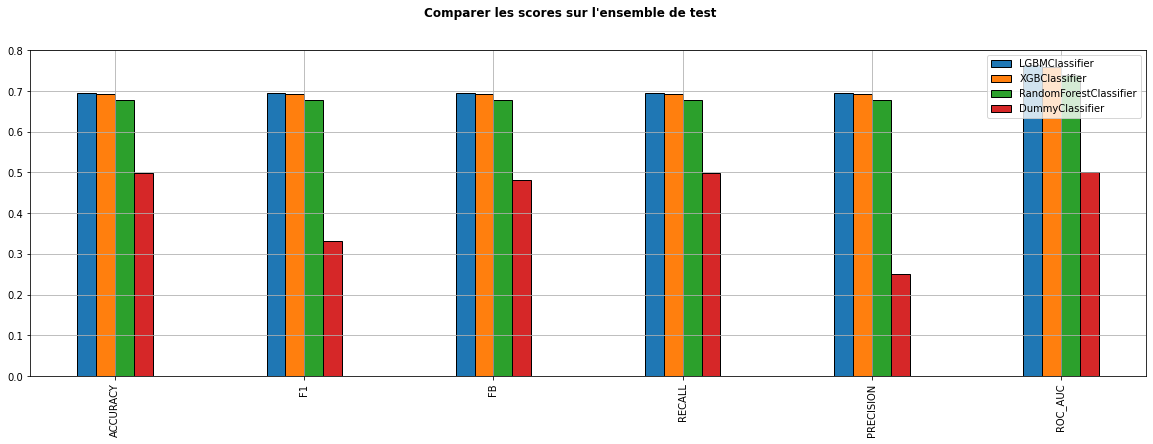

In [15]:
f, axe = plt.subplots(1,1, figsize=(20,6))

sel_cols = score_results_test.columns

score_results_test[sel_cols].sort_values('ACCURACY',
                                 ascending=False,
                                 axis=1).plot.bar(ec='k', width=0.4,ax=axe)

plt.suptitle("Comparer les scores sur l'ensemble de test",fontweight='bold')
plt.grid()
plt.show()


### Check Feature Importance

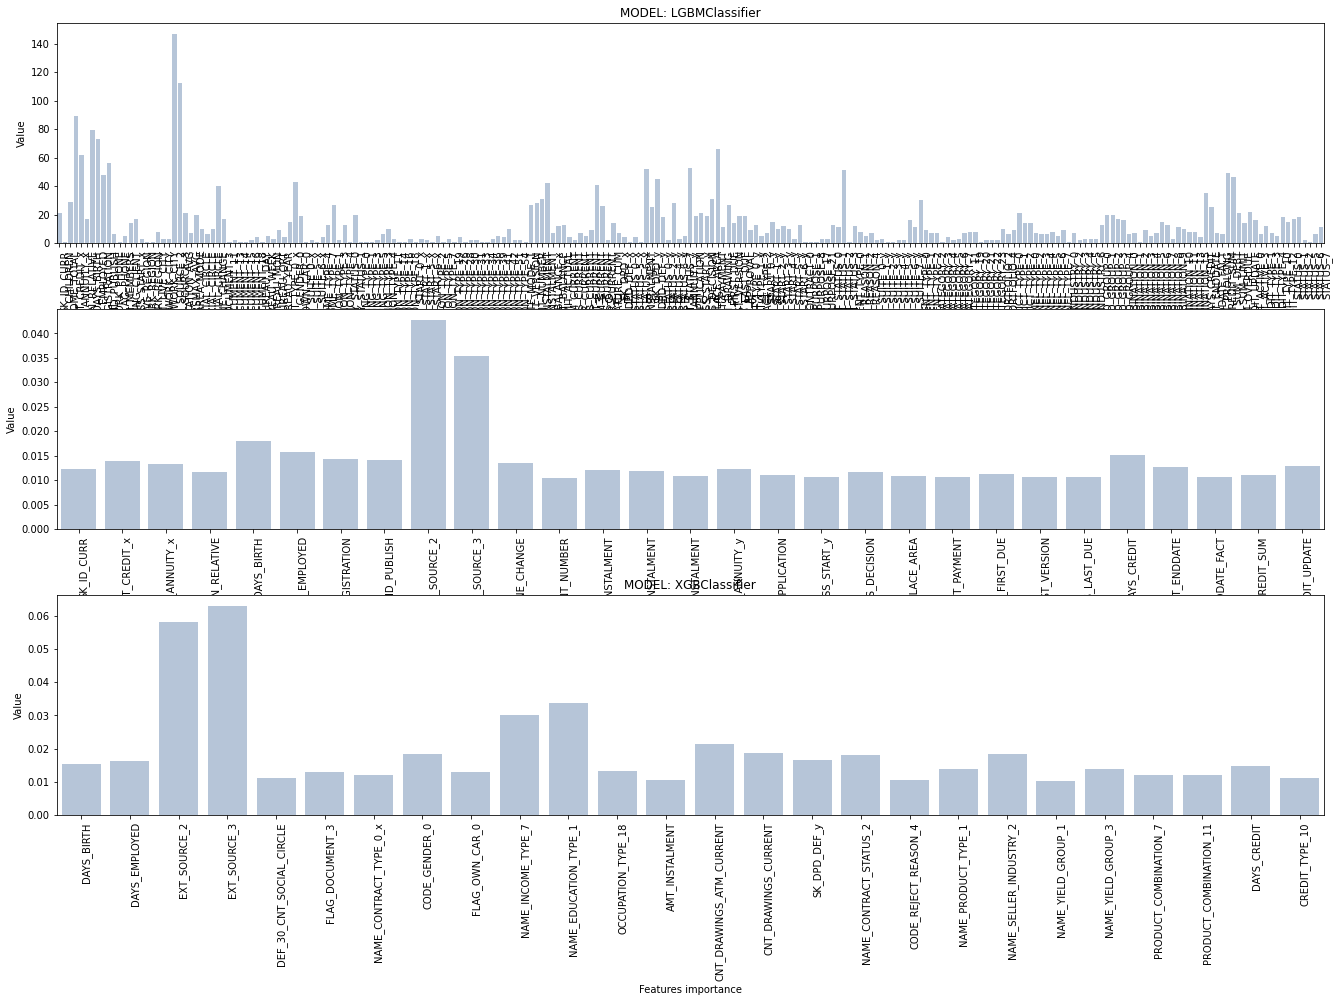

In [16]:
f, (axe1,axe2,axe3) = plt.subplots(3,1, figsize=(22,10)) #,sharex=True)

tnx=0
axe=[axe1,axe2,axe3]
for model_idx in Classifiers:
  if model_idx != 'DummyClassifier':
    ax1=axe[tnx]
    df_values=Imp_Feat[model_idx]
    importance_plot = df_values['Value']#[df_values['Value']> 0.01]
    hg=sns.barplot(importance_plot['Feature'], importance_plot['Value'], color = "lightsteelblue",ax=ax1)
    ax1.set_title('MODEL: '+ model_idx)
    if tnx<2:
      ax1.set_xlabel(" ")
    else:
      ax1.set_xlabel("Features importance")
    plt.setp(hg.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    f.subplots_adjust(left=0.1,bottom=0, right=0.9, top=1.1, wspace=0.3, hspace=0.3)
    tnx=tnx+1

In [17]:
tnx

3